In [41]:
import os 
import numpy as np

from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

from src.default_paths import path_root 
from src.io import read_pkl
from src.mappings import model_names, task_names
from src.utils import list_dir
from src.metrics import expected_calibration_error as ece

In [2]:
tasks = list_dir(os.path.join(path_root, "data/labels"))
models = ["count_sk_noextension_gbm", "clmbr_stanford", "clmbr_stanford_cp"]
colours = {
    "count_sk_noextension_gbm": "dodgerblue",
    "clmbr_stanford": "crimson", 
    "clmbr_stanford_cp": '#7D529D',
}

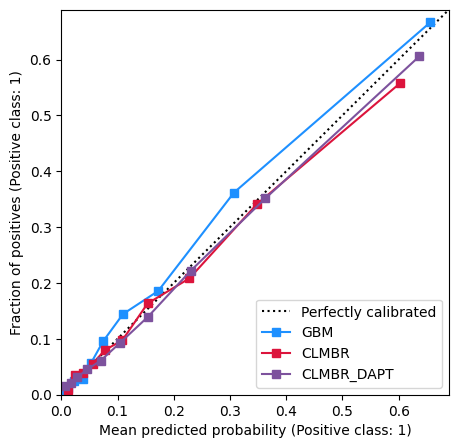

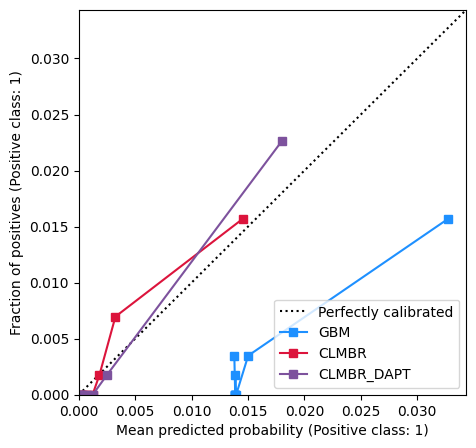

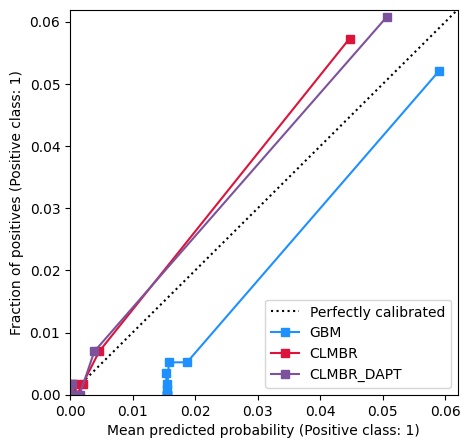

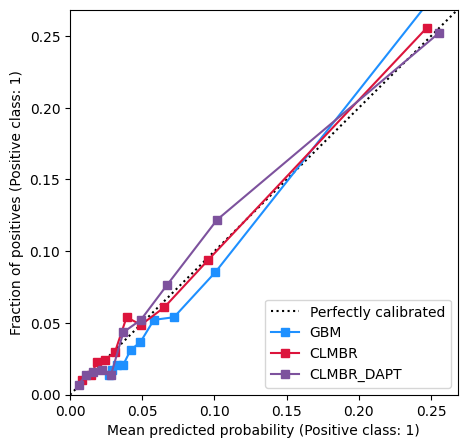

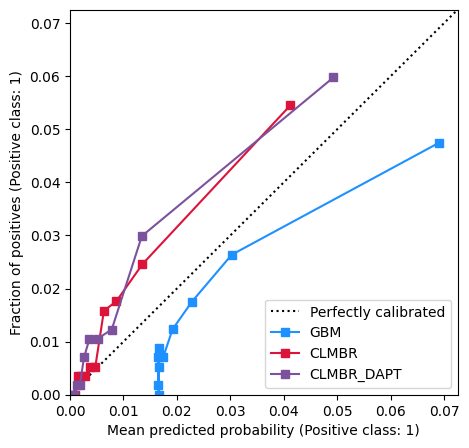

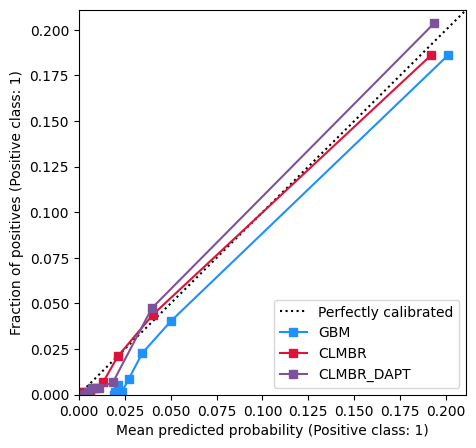

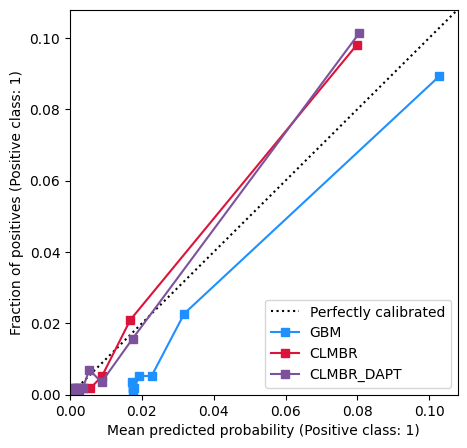

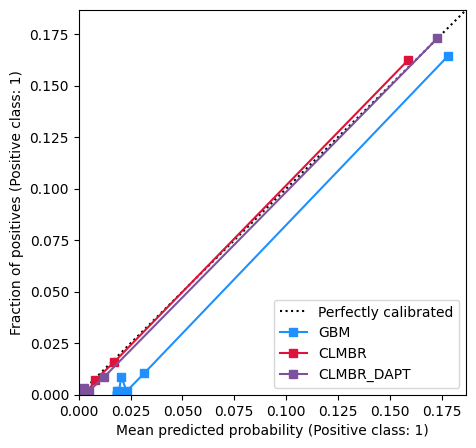

In [3]:
for task in tasks:
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    x_max = 0
    for model in models:    
        results = read_pkl(
            os.path.join(
                path_root, f"data/evaluate/adapter_models/{model}/{task}/results.pkl"
            )
        )

        disp = CalibrationDisplay.from_predictions(
            results["labels"], 
            results["predictions"], 
            n_bins=10, 
            strategy="quantile",
            ax=ax,
            name=model_names[model],
            color=colours[model],
        )

        x_max = max(disp.prob_pred.max(), x_max)

    ax.set_xlim([0, x_max*1.05])
    ax.set_ylim([0, x_max*1.05])
    plt.savefig(f"test_{task}.png")
    plt.show()

In [44]:
for task in tasks:
    for model in models:    
        results = read_pkl(
            os.path.join(
                path_root, f"data/evaluate/adapter_models_few_shots/{model}_8_iter0/{task}/results.pkl"
            )
        )

        ece_uncorrected = round(ece(results["labels"], results["predictions"], quantile_bins=True),3)
        ece_corrected = round(ece(results["labels"], correct_risk(results["predictions"], 0.5, results["labels"].mean()), quantile_bins=True),3)

        print(f"{model_names[model]}, {task_names[task]}, {ece_uncorrected=}, {ece_corrected=}")

GBM, Long LOS, ece_uncorrected=0.37, ece_corrected=0.064
CLMBR, Long LOS, ece_uncorrected=0.342, ece_corrected=0.018
CLMBR_DAPT, Long LOS, ece_uncorrected=0.311, ece_corrected=0.036
GBM, Hyponatremia, ece_uncorrected=0.371, ece_corrected=0.002
CLMBR, Hyponatremia, ece_uncorrected=0.488, ece_corrected=0.002
CLMBR_DAPT, Hyponatremia, ece_uncorrected=0.316, ece_corrected=0.001
GBM, In-hospital Mortality, ece_uncorrected=0.082, ece_corrected=0.006
CLMBR, In-hospital Mortality, ece_uncorrected=0.396, ece_corrected=0.002
CLMBR_DAPT, In-hospital Mortality, ece_uncorrected=0.212, ece_corrected=0.003
GBM, 30-day Readmission, ece_uncorrected=0.379, ece_corrected=0.013
CLMBR, 30-day Readmission, ece_uncorrected=0.347, ece_corrected=0.034
CLMBR_DAPT, 30-day Readmission, ece_uncorrected=0.35, ece_corrected=0.029
GBM, Hyperkalemia, ece_uncorrected=0.319, ece_corrected=0.017
CLMBR, Hyperkalemia, ece_uncorrected=0.487, ece_corrected=0.006
CLMBR_DAPT, Hyperkalemia, ece_uncorrected=0.487, ece_corrected=

In [8]:
results["predictions"]

array([0.61099355, 0.50005066, 0.50005066, ..., 0.50000039, 0.38900645,
       0.61099355])

In [35]:
def correct_risk(
    p: np.ndarray,
    b: float,
    b1: float,
) -> np.ndarray:
    """ 
    correct probability given new base rate according to https://dl.acm.org/doi/10.5555/1642194.1642224
    """
    return b1*((p-p*b)/(b-p*b + b1*p - b*b1))